# Is there a relationship between a person's personality and Cocaine consumption?

According to the National Institute of Drug Abuse the drug usage related cost can reach or even exceed the annual $740 billion dollar in the USA: accidents from driving under the influence, crimes caused by or driven by drugs, healthcare cost, or when people dropout from potential workforce. The deaths caused by drug overdose is steadily increasing every year.

Our purpose of the study is to identify the groups of people who are more likely to become users of a certain drug, so that we can reach them with preventive programs or targeted education that can keep them from becoming drug users.

**[Cocaine](https://adf.org.au/drug-facts/cocaine/#wheel)**

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

# libraries for cleaning and preprocessing data
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# libraries for evaluating models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from helper import *
from visualizations import *
from modeling import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Reading Data

In [2]:
drugs = pd.read_csv('data/drug_consumption.data', header=None, index_col=0)

In [3]:
# rename columns
drugs.columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
                 'Neuroticism', 'Extraversion', 'Openness-to-experience',
                 'Agreeableness', 'Conscientiousness', 'Impulsive',
                 'Sensation-seeking', 'Alcohol', 'Amphet', 'Amyl', 'Benzos',
                 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy',
                 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
                 'Nicotine', 'Semer', 'VSA']

In [4]:
personality_cols = ['Neuroticism', 'Extraversion', 'Openness-to-experience',
                    'Agreeableness', 'Conscientiousness', 'Impulsive',
                    'Sensation-seeking']

In [5]:
# Convert standardized values into categories
category_converter(drugs)

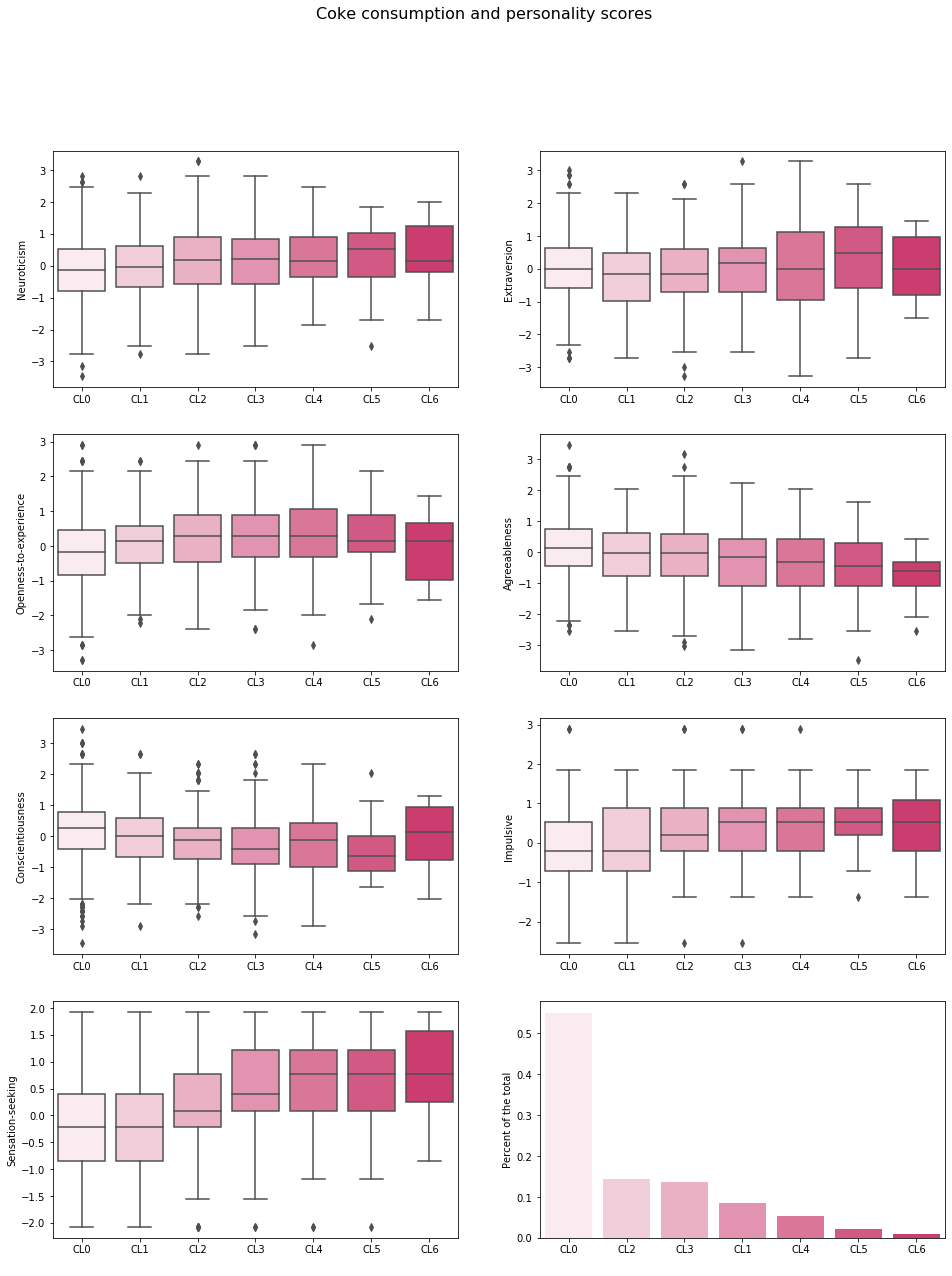

In [6]:
# plot distribution of personalities for each class for Coke
plot_personality(drugs, personality_cols, 'Coke')

In [7]:
# define drug columns
drug_cols = ['Alcohol', 'Amphet', 'Amyl', 'Benzos',
             'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy',
             'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
             'Nicotine', 'Semer', 'VSA']

# define user and non-user for each drug
for col in drug_cols:
    drugs[f"{col}_User"] = [0 if (x == 'CL0') | (x == 'CL1') else 1
                            for x in drugs[col]]

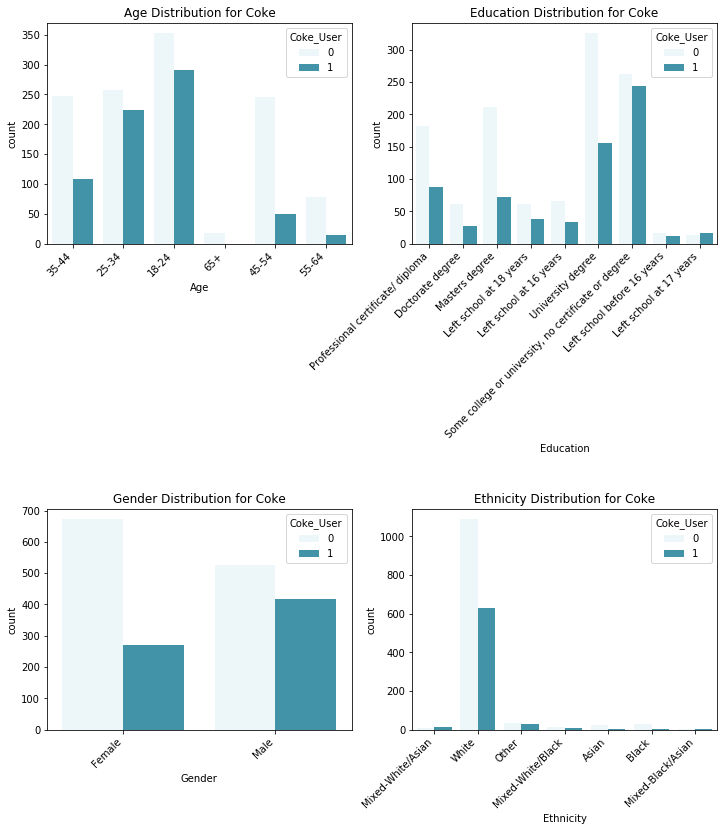

In [8]:
plot_feature_dist(drugs, 'Coke')

In [9]:
drugs = encoding(drugs)

In [10]:
# filter for just Coke Users
coke = drugs[['Coke_User', 'Age', 'Gender', 'Education',
             'Country', 'Ethnicity'] + personality_cols]

coke.rename({'Coke_User': 'User'}, axis=1, inplace=True)
coke.drop(columns=['Country', 'Ethnicity'], axis=1, inplace=True)

# save coke DataFrame for future use
coke.to_csv('data/coke.csv', index=False)

In [11]:
sns.reset_orig()

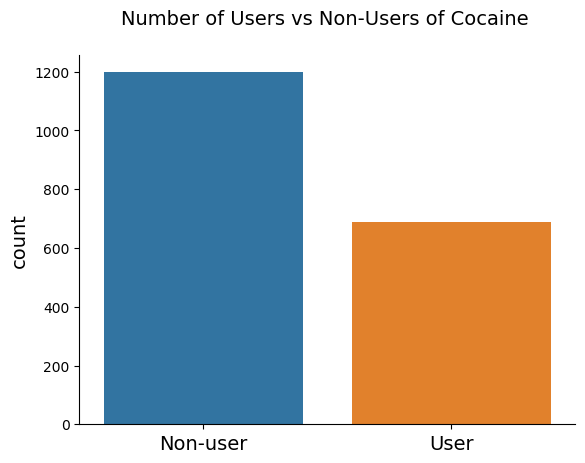

In [12]:
sns.countplot(coke['User'])
plt.title(f'Number of Users vs Non-Users of Cocaine \n',
          fontsize=14)
plt.xticks(np.arange(len(['Non-user', 'User'])),
           labels=['Non-user', 'User'],
           fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xlabel('')
sns.despine(left=False, bottom=False)
plt.savefig('img/users_vs_nonusers - coke.png',
            bbox_inches='tight');

## Preprocessing Data

In [13]:
coke = pd.read_csv('data/coke.csv')
coke.head()

,User,Age,Gender,Education,Neuroticism,Extraversion,Openness-to-experience,Agreeableness,Conscientiousness,Impulsive,Sensation-seeking
0,0,2,0,5,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,1,1,1,8,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0,2,1,5,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,1,0,0,7,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0,2,0,8,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Modeling

In [14]:
# define feature and target variables
y = coke['User']
X = coke.drop('User', axis=1)

In [15]:
# train-test split for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=220)

In [16]:
# scale data for Logistic Regression, KNN, and SVM
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

scale = StandardScaler()

X_train_scale.loc[:, ['Age', 'Education']] = scale.fit_transform(
    X_train_scale.loc[:, ['Age', 'Education']])
X_test_scale.loc[:, ['Age', 'Education']] = scale.transform(
    X_test_scale.loc[:, ['Age', 'Education']])

### Logistic Regression

In [18]:
grid_log = {'C': [0.001, 0.005],
            'penalty': ['l1', 'l2']}

gs_log = run_gridsearch_scaled(LogisticRegression, grid_log,
                               X_train_scale, X_test_scale,
                               y_train, y_test, random_state=220)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'C': 0.001, 'penalty': 'l2'}
Train score: 0.686
Test score: 0.687


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


### Random Forest

In [20]:
grid_forest = {'n_estimators': [300, 500, 800],
               'max_depth': [10, 25, 30],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2],
               'max_features': ['log2']}

gs_forest = run_gridsearch(RandomForestClassifier, grid_forest,
                           X_train, X_test, y_train,
                           y_test, random_state=220)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


Best params: {'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Train score: 0.693
Test score: 0.687


### LightGBM

In [23]:
grid_lgb = {'learning_rate': [0.05, 0.1],
            'max_depth': [5, 7],
            'min_child_weight': [6, 7],
            'subsample': [0.1, 0.3]}

gs_lgb = run_gridsearch(lgb.LGBMClassifier, grid_lgb,
                        X_train, X_test,
                        y_train, y_test, random_state=220)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


Best params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.1}
Train score: 0.688
Test score: 0.692


### KNN

In [27]:
grid_knn = {'n_neighbors': [60, 64, 70]}

gs_knn = run_gridsearch_scaled(KNeighborsClassifier, grid_knn,
                               X_train_scale, X_test_scale,
                               y_train, y_test)

pickle.dump(gs_knn, open('models/coke.sav', 'wb'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_neighbors': 64}
Train score: 0.686
Test score: 0.711


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


### SVM

In [30]:
grid_svm = {'C': [100, 1000],
            'class_weight': [None],
            'kernel': ['linear', 'rbf']}

gs_svm = run_gridsearch_scaled('SVM', grid_svm,
                               X_train_scale, X_test_scale,
                               y_train, y_test, random_state=220)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


Best params: {'C': 100, 'class_weight': None, 'kernel': 'linear'}
Train score: 0.684
Test score: 0.687


## Findings

### ROC Curve

We used Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) scores to compare which classification method performed the best. The ROC curve shows the ratio of True Positive and False Positive rates. The perfect model (red dotted line) would show an AUC of 1 and a ROC curve that looks like an upside-down 'L', because the perfect model would show 100% True Positives. The black dotted line shows the ROC curve of a random guess.

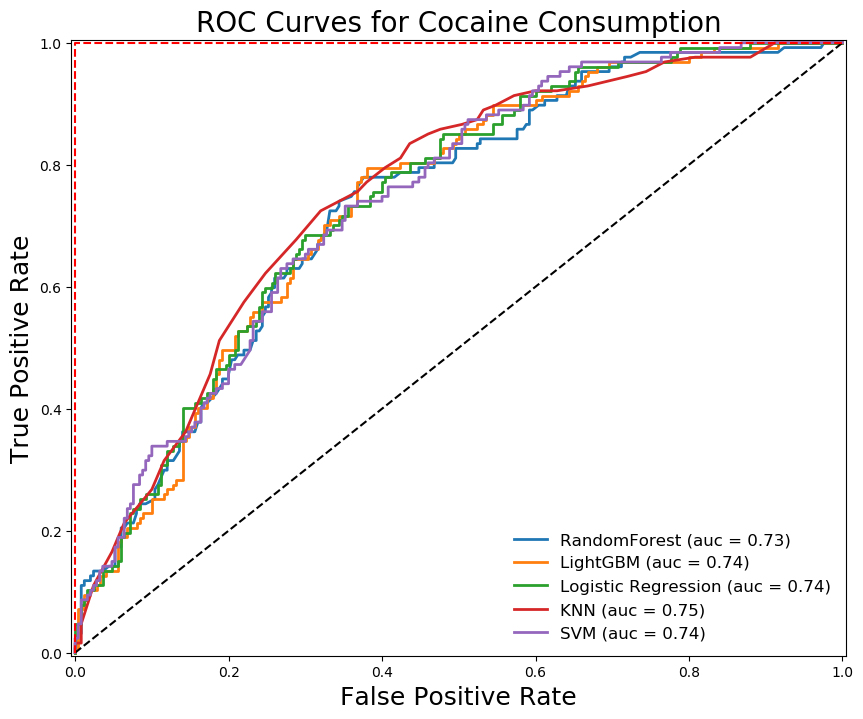

In [31]:
models = [gs_forest, gs_lgb, gs_log, gs_knn, gs_svm]

model_names = ['RandomForest', 'LightGBM',
               'Logistic Regression', 'KNN', 'SVM']

plot_roc_curve(models, model_names, X_test, y_test, 'Cocaine', X_test_scale)

### Interpreting LightGBM Results

I chose to focus on the LightGBM model to analyze the accuracy of predictions and which features are most important in predicting Cannabis users.

In [33]:
gs_knn = pickle.load(open('models/coke.sav', 'rb'))

#### Confusion Matrix

The confusion matrix below shows the percent accuracy of predictions. The KNN model was 71.1% accurate in predicting whether a person was a user (17%) or a nonuser (54%).

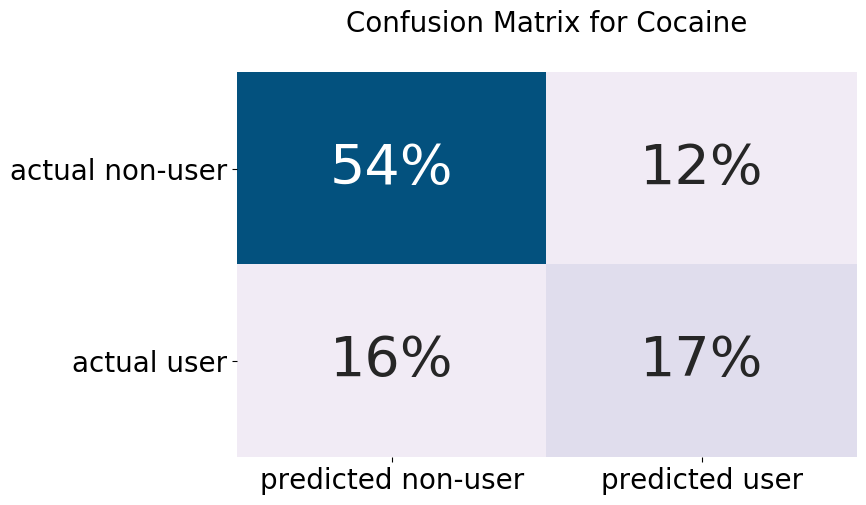

In [34]:
plot_confusion_matrix(y_test, X_test_scale, gs_knn, 'Cocaine')
plt.savefig('img/coke_matrix.png', bbox_inches='tight');

## Conclusion

Based on the 5 classification models, their demographics (age, gender, and education level) and their personalities had accuracy levels of 68-71% in predicting cocaine users.